In [1]:
from zhh import zhh_cuts, fetch_preselection_data, Cut, ProcessCategories, fs_columns
import zhh, os, ROOT
from glob import glob
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def plot_counts(tree):
    pdg = np.array(tree[f'final_state_counts/final_state_counts.first'].array(entry_stop=1)[0])
    count = np.array(tree[f'final_state_counts/final_state_counts.second'].array()).sum(axis=0)
    xpos = np.arange(len(fs_columns))
    
    fig, ax = plt.subplots()
    ax.set_xticks(xpos)
    ax.set_xticklabels(fs_columns, rotation=45)
    ax.set_xlim(-1, len(fs_columns))
    ax.bar(xpos, count)
    ax.set_title('Final state counts')
    ax.set_yscale('log')
    
#tf = ur.open('/gpfs/home/ilc/bliewert/DevRepositories/ZHH/scripts/zhh_AIDA.root')
#plot_counts(tf['FinalStates'])

In [3]:
prefix1 = '/home/ilc/bliewert/jobresults/550-llhh-full-ana'
#prefix2 = '/home/ilc/bliewert/jobresults/550-2l4q-ana'

files = glob(f'{prefix1}/*.root')# + glob(f'{prefix2}/*.root')
#output = list(filter(lambda path: any([elem in path for elem in ['e1e1hh', 'e2e2hh', 'P6f']]), files))
output = files
output.sort()

print(f'Found {len(output)} output files')

Found 0 output files


In [4]:
from configurations import AnalysisChannel
WORK_ROOT = '/home/ilc/bliewert/jobresults/analysis'

llhh_llqqh = AnalysisChannel('llhh_llqqh', zhh_cuts('llhh'),# + [EqualCut('ll_dilepton_type', 11)],
                               define_bkg=lambda a: True,
                               define_sig=lambda b: True)

llhh_llqqh.initialize(WORK_ROOT, root_files=output, trees=['FinalStates', 'EventObservablesLL', 'KinFitLLZHH'])

rf = llhh_llqqh.rf
tree = rf['Merged']

In [5]:
count = np.array(tree[f'final_state_counts/final_state_counts.second'].array()).sum(axis=0)

In [6]:
np.unique(np.array(tree['process'].array()), return_counts=True)

(array([1111, 1112, 1113, 1311, 1312, 1511, 2161, 2162, 2163, 2341, 2342,
        2520], dtype=int32),
 array([1209031,  599156,  604309,  592744,  592924,  549201, 1192256,
         604855,  604616,  592419,  586459,  596003]))

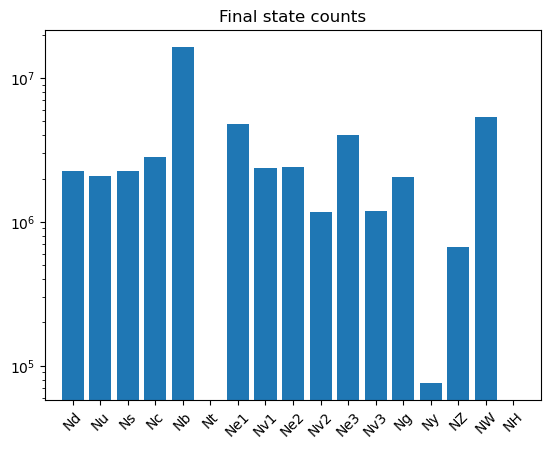

In [7]:
plot_counts(tree)

In [ ]:
llhh_llqqh.fetch('ll')
data = llhh_llqqh.summary

# calculate and apply weights
weights, processes = llhh_llqqh.weight()

Process e1e1hh       with Pol eL.pL has    604415 events xsec=5.121E-04 wt=5.338E-07
Process e1e1hh       with Pol eR.pR has    604616 events xsec=8.317E-03 wt=1.788E-06
Process e2e2hh       with Pol eL.pL has    299577 events xsec=1.266E-02 wt=2.663E-05
Process e2e2hh       with Pol eR.pR has    299579 events xsec=8.107E-03 wt=3.518E-06
Process e3e3hh       with Pol eL.pL has    302104 events xsec=1.263E-02 wt=2.634E-05
Process e3e3hh       with Pol eR.pR has    302205 events xsec=8.088E-03 wt=3.479E-06
Process n1n1hh       with Pol eL.pL has    296372 events xsec=4.074E-02 wt=8.660E-05
Process n1n1hh       with Pol eR.pR has    296372 events xsec=1.601E-02 wt=7.021E-06
Process n23n23hh     with Pol eL.pL has    296373 events xsec=5.006E-02 wt=1.064E-04
Process n23n23hh     with Pol eR.pR has    296551 events xsec=3.204E-02 wt=1.404E-05
Process qqhh         with Pol eL.pL has    274649 events xsec=2.559E-01 wt=5.870E-04
Process qqhh         with Pol eR.pR has    274552 events xsec=1.6

In [11]:
# split into signal and background
pdgs = np.array(rf['Merged/final_state_counts.first'].array(entry_stop=1)[0])
print(pdgs)

counts = np.array(rf['Merged/final_state_counts.second'].array())
n_d = counts[:, 0]
n_u = counts[:, 1]
n_s = counts[:, 2]
n_c = counts[:, 3]
n_b = counts[:, 4]
n_t = counts[:, 5]
n_q = n_d + n_u + n_s + n_c + n_b + n_t

n_v = counts[:, 7] + counts[:, 9] + counts[:, 11]
n_e = counts[:, 6]
n_mu = counts[:, 8]
n_tau = counts[:, 10]
n_charged_lep = n_e + n_mu + n_tau
n_b_from_higgs = np.array(tree['n_b_from_higgs'].array(), dtype='B')

#sig = subset[subset['process']  > 0]
#bkg = subset[subset['process'] == 0]

#is_sig = np.isin(data['id'], sig['id'])
#is_bkg = np.isin(data['id'], bkg['id'])

is_sig = np.isin(np.array(rf['Merged/process']), [ProcessCategories.e1e1hh, ProcessCategories.e2e2hh, ProcessCategories.e3e3hh ])
is_sig_4b = is_sig & (n_b_from_higgs == 4)
is_bkg = np.isin(np.array(rf['Merged/process']), [ProcessCategories.e1e1qqh, ProcessCategories.e2e2qqh, ProcessCategories.e3e3qqh ])

data['is_sig'] = is_sig_4b
data['is_bkg'] = is_bkg

print(f'Signal:Background = {is_sig_4b.sum()}:{is_bkg.sum()}')

[ 1  2  3  4  5  6 11 12 13 14 15 16 21 22 23 24 25]


Signal:Background = 817590:2401727


In [12]:
bmax_old = np.array([tree['bmax12'].array(), tree['bmax22'].array(), tree['bmax32'].array(), tree['bmax42'].array()]).T
bmax_new = np.array([tree['bmax1'].array(), tree['bmax2'].array(), tree['bmax3'].array(), tree['bmax4'].array()]).T

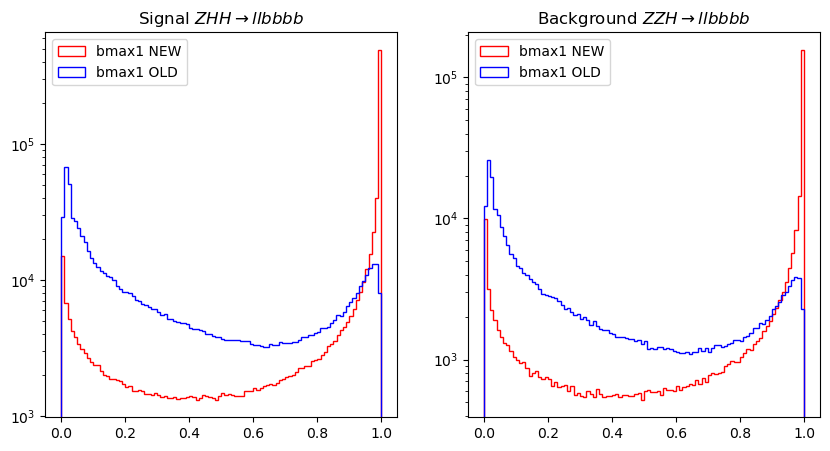

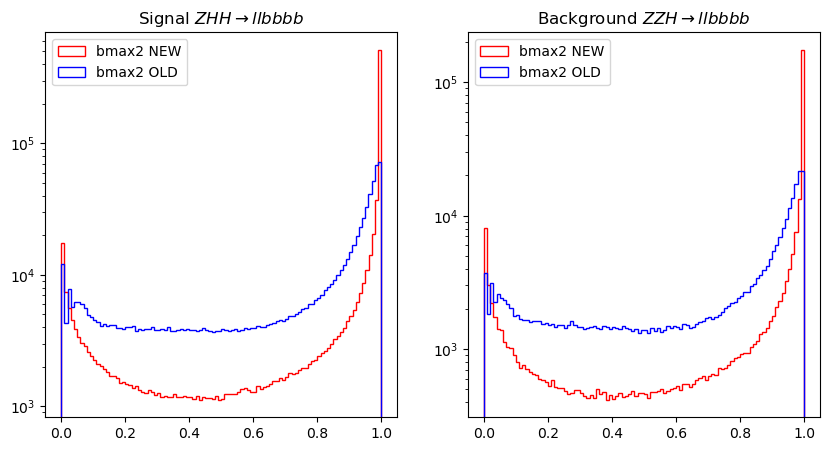

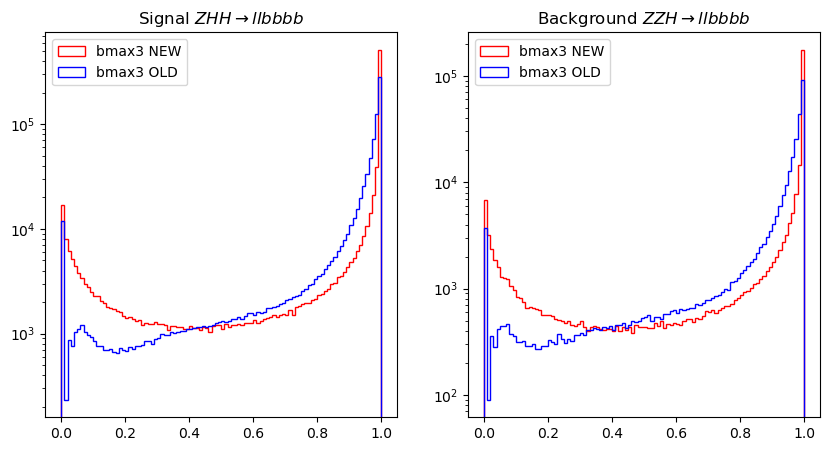

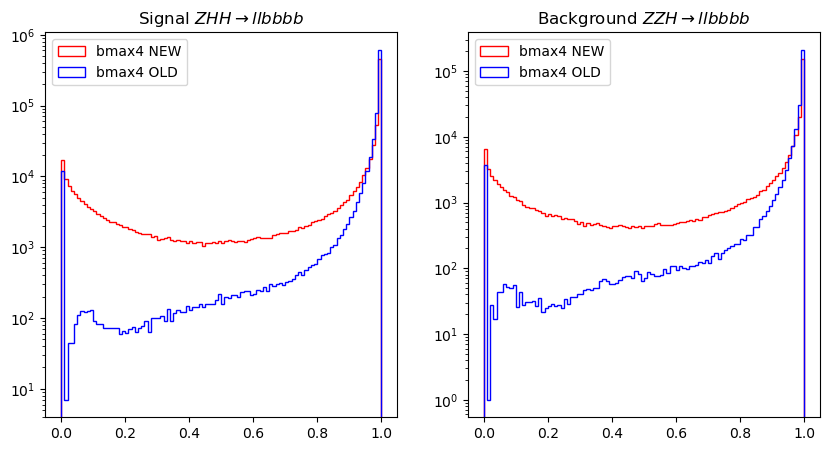

In [13]:
for idx in [0, 1, 2, 3]:
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
    for mask, title, ax in [
        (is_sig_4b, rf'Signal $ZHH \rightarrow llbbbb$', ax1),
        (is_bkg, rf'Background $ZZH \rightarrow llbbbb$', ax2)
    ]:
        mask = mask & (n_b == 4)
        ax.hist(bmax_new[mask, idx], bins=100, histtype='step', label=f'bmax{idx+1} NEW', color='red')
        ax.hist(bmax_old[mask, idx], bins=100, histtype='step', label=f'bmax{idx+1} OLD', color='blue')

        ax.set_title(title)
        ax.set_yscale('log')
        ax.legend()

In [15]:
assert(np.array(tree['error_code'].array()).sum() == 0)

In [ ]:
from phc import module_reload
module_reload('zhh')

from zhh import calc_preselection_by_processes, apply_cuts, zhh_cuts
import numpy as np

from os.path import dirname, basename, splitext
from subprocess import run
from tabulate import tabulate, SEPARATING_LINE

def render_latex(latex:str, location:str):
    latex = latex.replace('_', '\\textunderscore ')
    latex = latex.replace('>=', '$\geq$')
    latex = latex.replace('<=', '$\leq$')
    
    content = "\documentclass[9pt]{article}\n\\usepackage[a4paper,margin=1in,landscape]{geometry}\n\\begin{document}\n " + latex + " \n\\end{document}"

    drn = dirname(location)
    se = splitext(basename(location))

    with open(f'{drn}/{se[0]}.tex', 'w') as f:
        f.write(content)
        
    run(['pdflatex', '-output-directory', drn, f'{drn}/{se[0]}.tex'])

In [ ]:
# TODO:
# class LazilyLoadedObject

In [9]:
from collections.abc import Callable
import abc

class FinalState:
    __metaclass__ = abc.ABCMeta
    
    def __init__(self, name:str, definition:Callable[[dict[str, np.ndarray]], np.ndarray]):
        self._name = name
        self._definition = definition
    
    @abc.abstractmethod
    def finalStateWrapper(self, tree:ur.WritableTree):
        counts = np.array(tree['final_state_counts.second'].array(), dtype='B')
        
        result = {
            'process': np.array(tree['process'].array(), dtype='I'),
            'n_d': counts[:, 0],
            'n_u': counts[:, 1],
            'n_s': counts[:, 2],
            'n_c': counts[:, 3],
            'n_b': counts[:, 4],
            'n_t': counts[:, 5],
            'n_b_from_higgs': np.array(tree['n_b_from_higgs'].array(), dtype='B'),
            'n_higgs': np.array(tree['n_higgs'].array(), dtype='B'),
        }
        
        result['n_q'] = result['n_d'] + result['n_u'] + result['n_s'] + result['n_c'] + result['n_b'] + result['n_t']
        result['n_v'] = counts[:, 7] + counts[:, 9] + counts[:, 11]
        result['n_e'] = counts[:, 6]
        result['n_mu'] = counts[:, 8]
        result['n_tau'] = counts[:, 10]
        result['n_charged_lep'] = result['n_e'] + result['n_mu'] + result['n_tau']
        
        return result
    
    @abc.abstractmethod
    def calcCrossSection(self, processes:np.ndarray, tree:ur.WritableTree):
        pass
    
    @abc.abstractmethod
    def calcExpectedEvents(self, tree:ur.WritableTree):
        pass # return self._definition(tree)
        

In [12]:
processes

array([( 0, 'e1e1hh', 'e1e1hh_LL', -1, -1, 0, 5.1213225e-04, 604415, 5.3381092e-07),
       ( 1, 'e1e1hh', 'e1e1hh_RR',  1,  1, 3, 8.3169974e-03, 604616, 1.7882585e-06),
       ( 2, 'e2e2hh', 'e2e2hh_LL', -1, -1, 0, 1.2660771e-02, 299577, 2.6625159e-05),
       ( 3, 'e2e2hh', 'e2e2hh_RR',  1,  1, 3, 8.1066675e-03, 299579, 3.5178259e-06),
       ( 4, 'e3e3hh', 'e3e3hh_LL', -1, -1, 0, 1.2632254e-02, 302104, 2.6342981e-05),
       ( 5, 'e3e3hh', 'e3e3hh_RR',  1,  1, 3, 8.0884285e-03, 302205, 3.4794120e-06),
       ( 6, 'n1n1hh', 'n1n1hh_LL', -1, -1, 0, 4.0738929e-02, 296372, 8.6599022e-05),
       ( 7, 'n1n1hh', 'n1n1hh_RR',  1,  1, 3, 1.6005259e-02, 296372, 7.0205137e-06),
       ( 8, 'n23n23hh', 'n23n23hh_LL', -1, -1, 0, 5.0057203e-02, 296373, 1.0640658e-04),
       ( 9, 'n23n23hh', 'n23n23hh_RR',  1,  1, 3, 3.2038786e-02, 296551, 1.4044944e-05),
       (10, 'qqhh', 'qqhh_LL', -1, -1, 0, 2.5591573e-01, 274649, 5.8702892e-04),
       (11, 'qqhh', 'qqhh_RR',  1,  1, 3, 1.6380228e-01, 2745

In [16]:
from zhh import combined_cross_section

In [ ]:
combined_cross_section(processes, ['e1e1hh', 'e2e2hh', 'e3e3hh'])

0.005217002645076718

In [128]:
fs_llHH = FinalState('llHH', lambda fs_counts: (
    np.isin(fs_counts['process'], [ProcessCategories.e1e1hh, ProcessCategories.e2e2hh, ProcessCategories.e3e3hh])))
fs_llHH_llbbbb = FinalState('llHH(llbbbb)', lambda fs_counts: (fs_counts['n_b_from_higgs'] == 4) & (
    np.isin(fs_counts['process'], [ProcessCategories.e1e1hh, ProcessCategories.e2e2hh, ProcessCategories.e3e3hh])))
fs_llqqH = FinalState('llqqH', lambda fs_counts: (
    np.isin(fs_counts['process'], [ProcessCategories.e1e1qqh, ProcessCategories.e2e2qqh, ProcessCategories.e3e3qqh])))

In [136]:
import phc
phc.module_reload('zhh')

In [137]:
from matplotlib.ticker import MultipleLocator
from phc import plot_hist, export_figures, set_colorpalette
from zhh import fig_ild_style, plot_preselection_by_event_categories, \
    calc_preselection_by_event_categories, plot_preselection_by_calc_dict, PlotContext, \
    Cut, WindowCut, LessThanEqualCut, GreaterThanEqualCut, EqualCut, zhh_cuts, \
    colorpalette_desy, annotate_cut, weighted_counts_by_categories, \
    plot_total_efficiency, plot_cut_efficiencies, annotate_cut, get_matplotlib_fonts

from zhh.plot.ild_style import ild_style_defaults
ild_style_defaults['fontname'] = 'Montserrat'

plot_options = {
    'llbbbb': [
        { 'xlabel': 'IsoLeptons', 'plot_hist_kwargs': { 'int_bins': True },
         'ild_style_kwargs': { 'xminor': False, 'xlocator': MultipleLocator(1), 'show_binning_on_y_scale': False, 'ild_text_position': 'upper right' } },
        { 'xlabel': 'm_{ll}', 'xlim': [40, 140], 'xunit': 'GeV' },
        { 'xlabel': 'm_{H1}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'm_{H2}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'p_{t}^{miss}', 'xlim': [0, 200], 'xunit': 'GeV' },
        { 'xlabel': 'thrust' },
        None
    ],
    'vvbbbb': [
        { 'xlabel': 'IsoLeptons', 'plot_hist_kwargs': { 'int_bins': True }, 'ild_style_kwargs': { 'xminor': False, 'xlocator': MultipleLocator(1), 'show_binning_on_y_scale': False } },
        { 'xlabel': 'm_{H1}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'm_{H2}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'p_{t}^{miss}', 'xlim': [0, 200], 'xunit': 'GeV' },
        { 'xlabel': 'thrust' },
        { 'xlabel': 'E_{vis}' },
        { 'xlabel': 'm_{HH}', 'xunit': 'GeV' },
        { 'xlabel': 'bmax3' },
        None
    ],
    'qqbbbb': [
        { 'xlabel': 'IsoLeptons', 'plot_hist_kwargs': { 'int_bins': True }, 'ild_style_kwargs': { 'xminor': False, 'xlocator': MultipleLocator(1), 'show_binning_on_y_scale': False } },
        { 'xlabel': 'm_{H1}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'm_{H2}', 'xlim': [0, 250], 'xunit': 'GeV' },
        { 'xlabel': 'p_{t}^{miss}', 'xlim': [0, 200], 'xunit': 'GeV' },
        { 'xlabel': 'thrust' },
        { 'xlabel': 'bmax4' },
        None
    ]
}

In [138]:
def reorder_dict(d, keys):
    result = {}
    for key in keys:
        if key in d:
            result[key] = d[key]
            
    return result

In [139]:
for mask in masks:
    print(len(mask), mask.sum())

8323973 3262929
8323973 1922345
8323973 1850645
8323973 1747189
8323973 630353
8323973 627785


Processing <Cut on nisoleps >= 2> before: 8323973 after: 3262929


  0%|          | 0/5 [00:00<?, ?it/s]

Processing <Cut on 71.2 <= m_{Z} <= 111.2> before: 3262929 after: 1922345


  0%|          | 0/5 [00:00<?, ?it/s]

Processing <Cut on 60.0 <= m_{H1} <= 180.0> before: 1922345 after: 1850645


  0%|          | 0/5 [00:00<?, ?it/s]

Processing <Cut on 60.0 <= m_{H2} <= 180.0> before: 1850645 after: 1747189


  0%|          | 0/5 [00:00<?, ?it/s]

Processing <Cut on p_{t}^{miss} <= 70.0> before: 1747189 after: 630353


  0%|          | 0/5 [00:00<?, ?it/s]

Processing <Cut on thrust <= 0.9> before: 630353 after: 627785


  0%|          | 0/5 [00:00<?, ?it/s]

/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/py-matplotlib/3.9.2-es64w5/lib/python3.11/site-packages/matplotlib/ticker.py:2926: RuntimeWarning: divide by zero encountered in scalar divide
  minorstep = majorstep / ndivs
/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/py-matplotlib/3.9.2-es64w5/lib/python3.11/site-packages/matplotlib/ticker.py:2932: RuntimeWarning: invalid value encountered in multiply
  locs = (np.arange(tmin, tmax) * minorstep) + t0


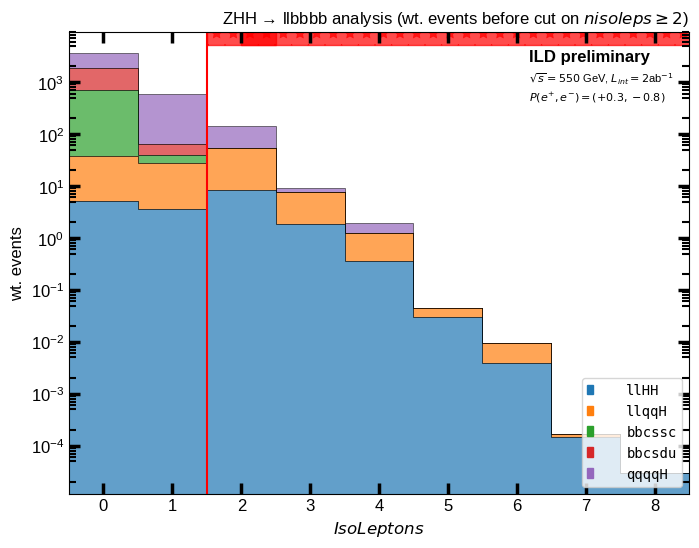

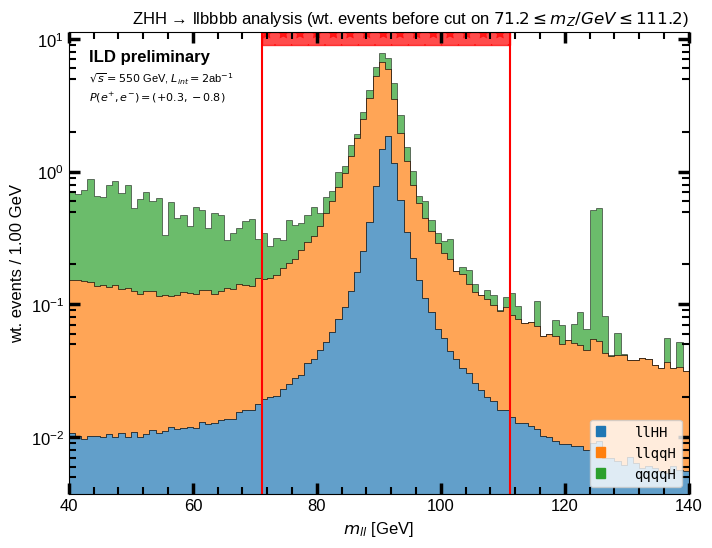

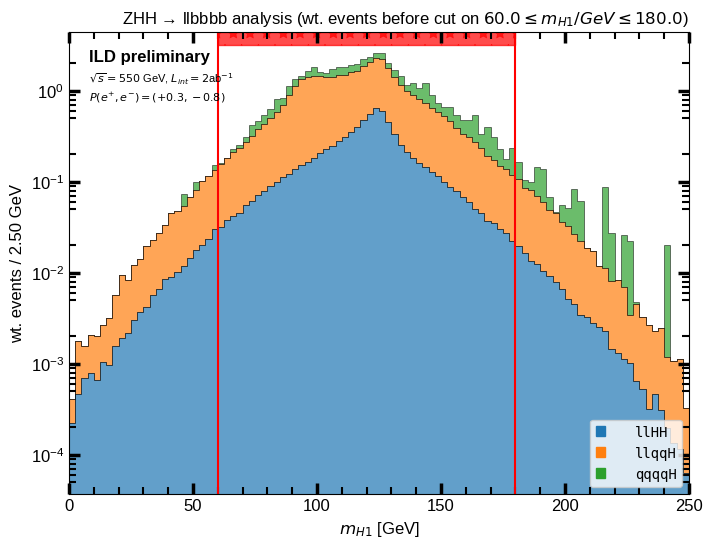

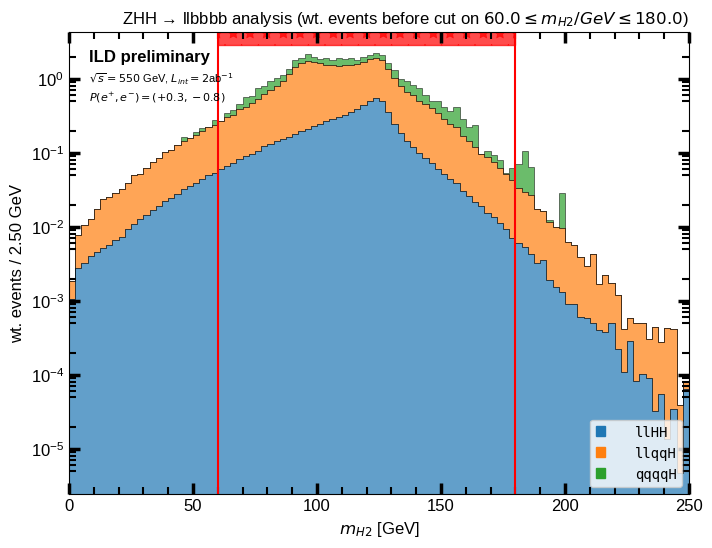

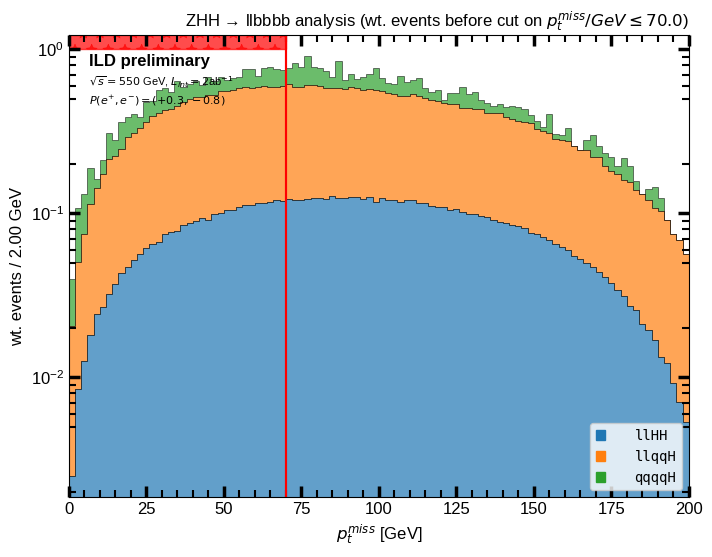

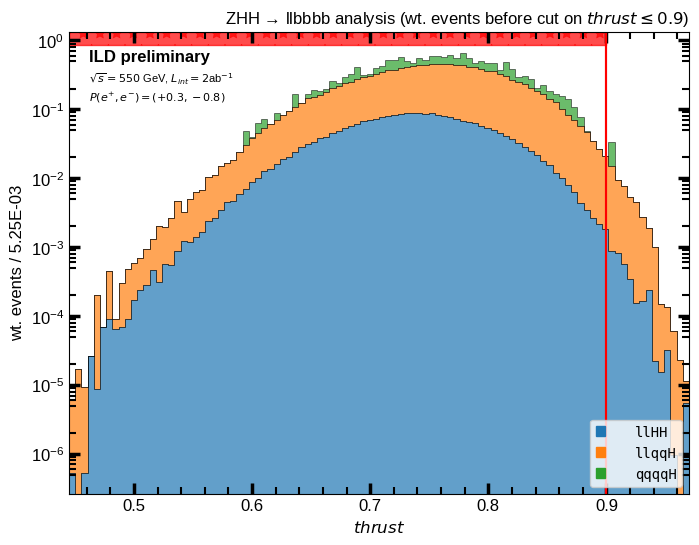

In [140]:
data = llhh_llqqh.summary
plot = True

# apply cuts
masks = []
figs = []
order = []

subset = data
for i, cut in enumerate(zhh_cuts('ll')):
    mask = cut(subset)
    masks.append(np.isin(data['id'], subset['id'][mask]))
    
    print('Processing', cut, 'before:', len(subset), 'after:', mask.sum())
    
    if plot:
        calc_dict = calc_preselection_by_event_categories(subset, processes, processes, quantity=cut.quantity)[0]
        context = PlotContext(colorpalette_desy)
        
        if not len(order):
            order = calc_dict.keys()
        
        prefix, suffix, categories_additional, yscale_default = 'full', 'bbbb', 5, 'log'
        hypothesis = 'llbbbb'
        plot_kwargs = {
            'bins': 100,
            'xlabel': cut.quantity,
            'yscale': yscale_default,
            'plot_flat': False,
            'ild_style_kwargs': {},
            'plot_hist_kwargs': {}
        } | plot_options[hypothesis][i]
        plot_kwargs['ild_style_kwargs']['title_postfix'] = rf' before cut on ${cut.formula(unit=plot_kwargs["xunit"] if ("xunit" in plot_kwargs) else None)}$'

        fig = plot_preselection_by_calc_dict(reorder_dict(calc_dict, order), hypothesis=hypothesis, **plot_kwargs)[0];
        annotate_cut(fig.axes[0], cut);
        figs += [fig]
        
    subset = subset[mask]
    
passed_presel_mask = np.isin(data['id'], subset['id'])

is_sig_and_passed = is_sig & passed_presel_mask
is_bkg_and_passed = is_bkg & passed_presel_mask

sig = data[is_sig_and_passed]
bkg = data[is_bkg_and_passed]

Processing <Cut on nisoleps >= 2> before: 4614775 after: 936075


  0%|          | 0/4 [00:00<?, ?it/s]

Processing <Cut on 71.2 <= m_{Z} <= 111.2> before: 936075 after: 280796


  0%|          | 0/4 [00:00<?, ?it/s]

Processing <Cut on 60.0 <= m_{H1} <= 180.0> before: 280796 after: 267868


  0%|          | 0/4 [00:00<?, ?it/s]

Processing <Cut on 60.0 <= m_{H2} <= 180.0> before: 267868 after: 252297


  0%|          | 0/4 [00:00<?, ?it/s]

Processing <Cut on p_{t}^{miss} <= 70.0> before: 252297 after: 120675


  0%|          | 0/4 [00:00<?, ?it/s]

Processing <Cut on thrust <= 0.9> before: 120675 after: 118591


  0%|          | 0/4 [00:00<?, ?it/s]

findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/py-matplotlib/3.9.2-es64w5/lib/python3.11/site-packages/matplotlib/ticker.py:2926: RuntimeWarning: divide by zero encountered in scalar divide
  minorstep = majorstep / ndivs
/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/py-matplotlib/3.9.2-es64w5/lib/python3.11/site-packages/matplotlib/ticker.py:2932: RuntimeWarning: invalid value encountered in multiply
  locs = (np.arange(tmin, tmax) * minorstep) + t0
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


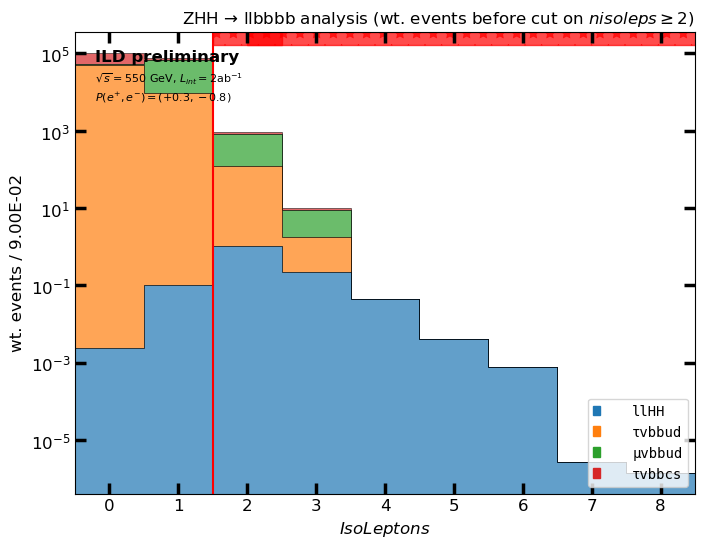

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


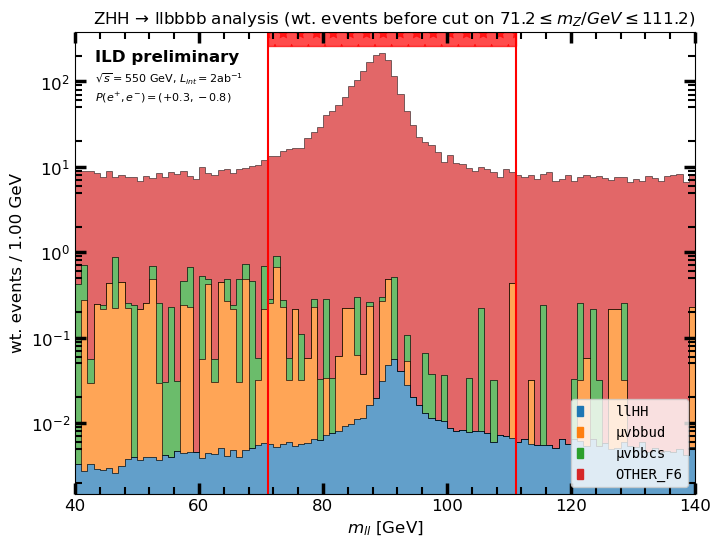

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


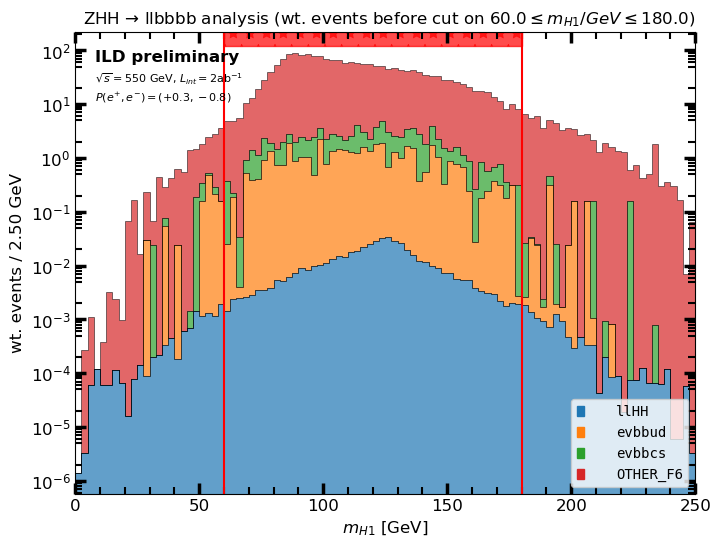

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


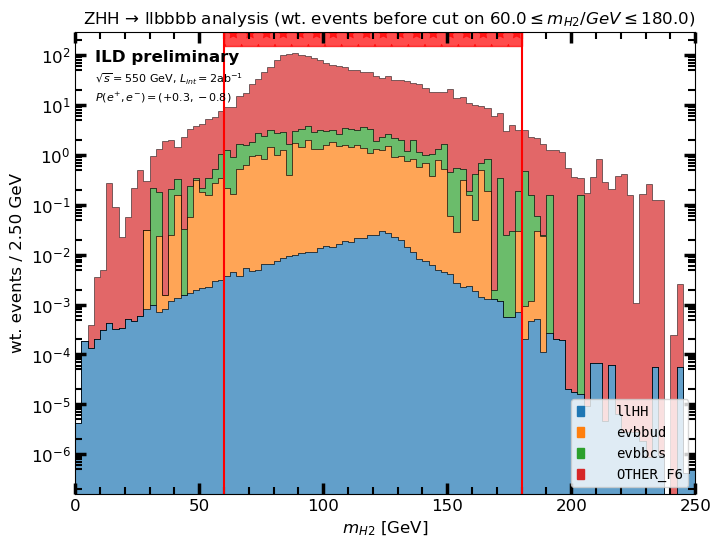

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

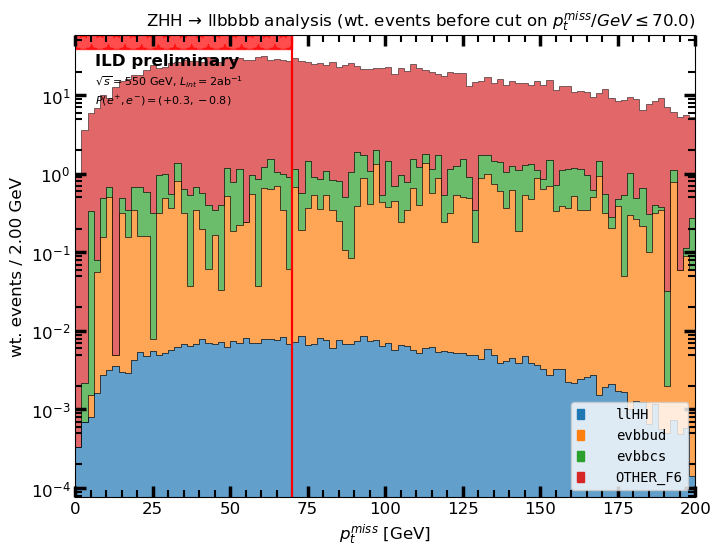

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


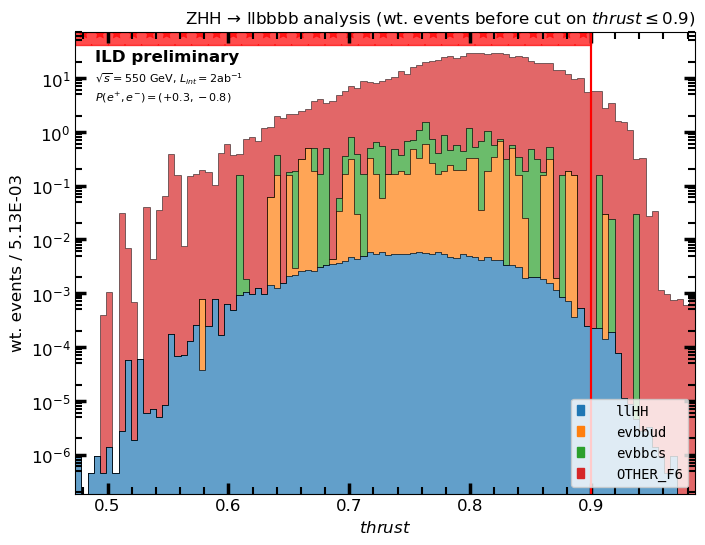

In [ ]:
data = llhh_llqqh.summary
plot = True

# apply cuts
masks = []
figs = []

subset = data
for i, cut in enumerate(zhh_cuts('ll')):
    mask = cut(subset)
    masks.append(mask)
    
    print('Processing', cut, 'before:', len(subset), 'after:', mask.sum())
    
    if plot:
        calc_dics = calc_preselection_by_event_categories(subset, processes, processes, quantity=cut.quantity)
        
        prefix, suffix, categories_additional, yscale_default = 'full', 'bbbb', 5, 'log'
        hypothesis = 'llbbbb'
        plot_kwargs = {
            'bins': 100,
            'xlabel': cut.quantity,
            'yscale': yscale_default,
            'plot_flat': False,
            'ild_style_kwargs': {},
            'plot_hist_kwargs': {}
        } | plot_options[hypothesis][i]
        plot_kwargs['ild_style_kwargs']['title_postfix'] = rf' before cut on ${cut.formula(unit=plot_kwargs["xunit"] if ("xunit" in plot_kwargs) else None)}$'

        fig = plot_preselection_by_calc_dict(calc_dics[0], hypothesis=hypothesis, **plot_kwargs)[0];
        annotate_cut(fig.axes[0], cut);
        figs += [fig]
        
    subset = subset[mask]
    
passed_presel_mask = np.isin(data['id'], subset['id'])

is_sig_and_passed = is_sig & passed_presel_mask
is_bkg_and_passed = is_bkg & passed_presel_mask

sig = data[is_sig_and_passed]
bkg = data[is_bkg_and_passed]

In [15]:
np.unique(weights['pid'], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35], dtype=uint32),
 array([698409,  19426, 583397, 365285, 557536, 367384, 402003, 204546,
        430103, 159887,  37500,  40000,  90406,  42237,  37500,  37500,
         20000,  20000,  35541,  20000,  20000,  20000,  20000,  20000,
         82118,  20000,  20000,  20000,  40000,  20000,  32019,  20000,
         20000,  40000,  31978,  20000]))

In [16]:
weights['pid'] == np.arange(len(weights))

array([False, False, False, ..., False, False, False])

In [13]:
weights

array([(10, 7027, 0, 0.01588139, 0, 2.6680733e-04),
       (10, 7027, 0, 0.01588139, 0, 2.6680733e-04),
       (10, 7027, 0, 0.01588139, 0, 2.6680733e-04), ...,
       ( 1, 1111, 3, 0.00051212, 0, 5.5657863e-05),
       ( 1, 1111, 3, 0.00051212, 0, 5.5657863e-05),
       ( 1, 1111, 3, 0.00051212, 0, 5.5657863e-05)],
      dtype=[('pid', '<u4'), ('process', '<u4'), ('polarization_code', 'u1'), ('cross_section', '<f4'), ('n_gen', '<u4'), ('weight', '<f4')])

In [57]:
features = ['evis', 'mzll', 'plmin', 'mbmax34', 'ptmiss', ('npfos', 'I'), 'mvalepminus']
names = []
dtypes = [('weight', 'f')] + []

for feat in features:
    if isinstance(feat, str):
        dtypes.append((feat, 'f'))
        names.append(feat)
    elif isinstance(feat, tuple):
        dtypes.append(feat)
        names.append(feat[0])

signal = np.zeros(len(sig), dtype=dtypes)
background = np.zeros(len(bkg), dtype=dtypes)

with ur.recreate('input.root') as file:
    for target, mask, treeName in (
        (signal, is_sig_and_passed, 'TreeS'),
        (background, is_bkg_and_passed, 'TreeB')
    ):
        target['weight'] = 1/len(target)
        
        for feat in names:
            target[feat] = np.array(rf[f'Merged/{feat}'].array())[mask]
        
        file[treeName] = target

In [14]:
from zhh import parse_polarization_code, sample_weight, ProcessCategories

In [15]:
ProcessCategories.inverted[1111]

'e1e1hh'

In [19]:
weights['weight'].sum()

19706.73

In [16]:
processes

array([(0, -1, -1, 0, 1.5881389e-02, 1790369, 5.5883871e-03),
       (1,  1,  1, 3, 2.4501428e-02,  994809, 3.2018062e-03),
       (2, -1, -1, 0, 5.1213225e-04, 1960368, 1.6458303e-04),
       (3,  1,  1, 3, 8.3169974e-03, 1976464, 5.4704241e-04),
       (4, -1, -1, 0, 1.9596890e+02,  492739, 2.5055945e+02),
       (5,  1,  1, 3, 7.3478470e+01,  320585, 2.9796158e+01)],
      dtype=[('pid', '<u2'), ('pol_e', '<i4'), ('pol_p', '<i4'), ('polarization_code', 'u1'), ('cross_sec', '<f4'), ('n_gen', '<u4'), ('weight', '<f4')])

In [50]:
mask_bkg.sum()

0

In [47]:
mask_sig.sum()

681589

In [6]:
import ROOT

In [8]:
rf = ur.open('/home/ilc/bliewert/jobresults/550-2l4q-ana/E550-TDR_ws.P6f_eexxxx.Gwhizard-3_1_5.eL.pL.I410026.0-0_AIDA.root')

In [9]:
rf.keys()

['EventObservablesQQ;1',
 'KinFitQQZZZ;2',
 'KinFitQQZZZ;1',
 'KinFitQQZZH;2',
 'KinFitQQZZH;1',
 'KinFitQQZHH;2',
 'KinFitQQZHH;1',
 'KinFitQQNMC;2',
 'KinFitQQNMC;1',
 'EventObservablesVV;1',
 'KinFitVVZZZ;2',
 'KinFitVVZZZ;1',
 'KinFitVVZZH;2',
 'KinFitVVZZH;1',
 'KinFitVVZHH;2',
 'KinFitVVZHH;1',
 'KinFitVVNMC;2',
 'KinFitVVNMC;1',
 'EventObservablesLL;1',
 'KinFitLLZZZ;2',
 'KinFitLLZZZ;1',
 'KinFitLLZZH;2',
 'KinFitLLZZH;1',
 'KinFitLLZHH;2',
 'KinFitLLZHH;1',
 'KinFitLLNMC;2',
 'KinFitLLNMC;1',
 'SLDCorrection;4',
 'SLDCorrection;3',
 'SLDCorrection;2',
 'SLDCorrection;1',
 'SLDStatus;4',
 'SLDStatus;3',
 'SLDStatus;2',
 'SLDStatus;1',
 'BHadronType;4',
 'BHadronType;3',
 'BHadronType;2',
 'BHadronType;1',
 'CHadronType;4',
 'CHadronType;3',
 'CHadronType;2',
 'CHadronType;1',
 'PxResidual;8',
 'PxResidual;7',
 'PxResidual;6',
 'PxResidual;5',
 'PxResidual;4',
 'PxResidual;3',
 'PxResidual;2',
 'PxResidual;1',
 'PyResidual;8',
 'PyResidual;7',
 'PyResidual;6',
 'PyResidual;5',
 

In [ ]:
with open(f'merge.C', 'w') as f:
    f.write('TChain *chain = new TChain("hAnl");\n')
    for i, path in enumerate(output):
        f.write(f'chain->Add("{path}");\n')
    f.write(f'chain->Merge("{llhh1_lvbbqq._work_dir}");\n')



AttributeError: 'AnalysisChannel' object has no attribute '_work_dir'

In [4]:
rf = llhh1_lvbbqq.rf

In [6]:
a = fetch_preselection_data(rf)

ValueError: could not broadcast input array from shape (0,) into shape (3500791,)

In [12]:
rf['EventObservablesLL']['mzll'].array()

<Array [] type='0 * float32'>

In [15]:
rf['EventObservablesLL/errorCode'].array()

<Array [] type='0 * int32'>

In [8]:
a.nbytes

NameError: name 'a' is not defined

In [ ]:
llhh1_lvbbqq.rf

<ReadOnlyDirectory '/' at 0x7fba6bc8da10>

In [40]:
sig_file = '/home/ilc/bliewert/DevRepositories/ZHH/scripts/sig/zhh_AIDA.root'
bkg_file = '/home/ilc/bliewert/DevRepositories/ZHH/scripts/bkg/zhh_AIDA.root'
merged_file = '/home/ilc/bliewert/DevRepositories/ZHH/scripts/target.root'

sig = ur.open(sig_file)
bkg = ur.open(bkg_file)
merged = ur.open(merged_file)
data = fetch_preselection_data(merged_file)

In [41]:
a = data[data['xx_nisoleps'] == 2]

a['event'][a['ll_mh1'] == 0]

array([579530], dtype=uint32)

In [42]:
a[a['event'] == 579530]

array([(1112, 3, 579530, 11, 0, 0, 0, 0.7567164, 343.5149, 42.100082, 199.53299, 2, 0, 0., 0., 0., 0, 0., 0., 133.12218, 134.04944, 339.01794, 131.85199, 97.89545, 0.000218, 0.84293354, 0.52192885, 0.00732994, 0.000218, 0.84293354, 0.52192885, 0.00732994, 0.9998361, 0.00014139, 0.00019322, 0.52192885, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2)],
      dtype=[('process', '<u4'), ('pol_code', 'u1'), ('event', '<u4'), ('event_category', 'u1'), ('ll_pass', 'u1'), ('vv_pass', 'u1'), ('qq_pass', 'u1'), ('xx_thrust', '<f4'), ('xx_e_vis', '<f4'), ('xx_pt_miss', '<f4'), ('xx_invmass_miss', '<f4'), ('xx_nisoleps', 'u1'), ('passed', 'u1'), ('weight', '<f4'), ('ll_mh1', '<f4'), ('ll_mh2', '<f4'), ('ll_dilepton_type', 'u1'), ('ll_mz', '<f4'), ('ll_mz_pre_pairing', '<f4'), ('vv_mh1', '<f4'), ('vv_mh2', '<f4'), ('vv_mhh', '<f4'), ('qq_mh1', '<f4'), ('qq_mh2', '<f4'), ('ll_bmax1', '<f4'), ('ll_bmax2', '<f4'), ('ll_bmax3', '<f4'), ('ll_bmax4', '<f4'), ('vv_bmax1', '<f4'), ('vv_bmax2', '<f4')

In [43]:
a[a['event'] == 579530]['xx_nisoleps']

array([2], dtype=uint8)

(MH1, MH2) 0 entries = (0, 0)


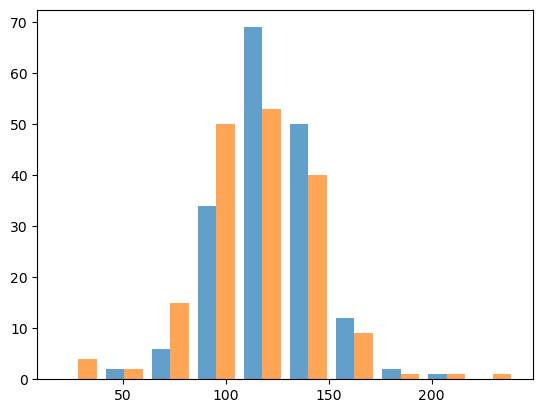

In [46]:
mode = 'LL_ZHH'
a = 'Boson2BeforeFit'
b = 'Boson2AfterFit'

mask = np.array(merged[f'EventObservablesLL/zhh_mz'].array() > 0)
err = np.array(merged[f'KinFit{mode}']['FitErrorCode'].array())
mask = (mask) #& (err == 0)

zhh_mh1 = np.array(merged[f'EventObservablesLL/zhh_mh1'].array())[mask]
zhh_mh2 = np.array(merged[f'EventObservablesLL/zhh_mh2'].array())[mask]

plt.hist([zhh_mh1, zhh_mh2], alpha=0.7)
print(f'(MH1, MH2) 0 entries = ({(zhh_mh1 == 0).sum()}, {(zhh_mh2 == 0).sum()})')

In [3]:
merged['FinalStates'].keys()

['run',
 'event',
 'error_code',
 'final_states',
 'final_state_counts',
 'final_state_counts/final_state_counts.first',
 'final_state_counts/final_state_counts.second',
 'process',
 'polarization_code',
 'cross_section',
 'event_category',
 'event_category_zhh',
 'n_fermion',
 'n_higgs',
 'n_b_from_higgs',
 'n_c_from_higgs']

In [5]:
merged['FinalStates/polarization_code'].array()

<Array [3, 3, 3, 3, 3, 3, 3, 3, ..., 0, 0, 0, 0, 0, 0, 0] type='198 * uint16'>

In [3]:
merged['FinalStates/final_state_counts/final_state_counts.first'].array(entry_stop=1)

<Array [[1, 2, 3, 4, 5, 6, ..., 16, 21, 22, 23, 24, 25]] type='1 * var * int32'>

In [4]:
# background: 2 leptons, 4 jets

In [5]:
merged['FinalStates/final_state_counts/final_state_counts.second'].array()

<Array [[0, 0, 0, 0, 4, 0, ..., 0, 0, 0, 0, 0], ...] type='198 * var * int32'>

In [6]:
np.isin(np.array(merged['FinalStates/process'].array()), [zhh.ProcessCategories.e1e1hh, zhh.ProcessCategories.e2e2hh]) & (np.array(merged['FinalStates/n_b_from_higgs'].array()) == 4)

array([ True, False,  True, False, False, False,  True,  True,  True,
       False, False,  True, False, False, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True,  True, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False,  True,  True,  True,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True,  True, False, False,  True, False,  True,
        True, False,  True,  True,  True, False, False, False, False,
       False, False, False,  True,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [7]:
#fsc = 
#merged['FinalStates']['n_higgs'].array() == 2

(Pre, Post) 0 entries = (0, 36)


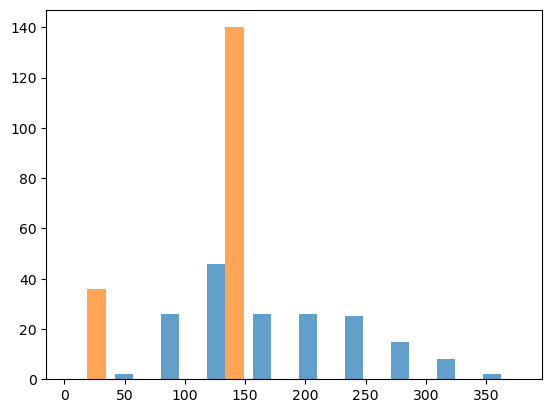

In [8]:
mode = 'LL_ZHH'
a = 'Boson2BeforeFit'
b = 'Boson2AfterFit'

mask = np.array(merged[f'KinFit{mode}']['nIsoLeptons'].array() == 2)
err = np.array(merged[f'KinFit{mode}']['FitErrorCode'].array())
mask = (mask) #& (err == 0)

preFit  = np.array(merged[f'KinFit{mode}'][a].array())[mask]
postFit = np.array(merged[f'KinFit{mode}'][b].array())[mask]

plt.hist([preFit, postFit], alpha=0.7)
print(f'(Pre, Post) 0 entries = ({(preFit == 0).sum()}, {(postFit == 0).sum()})')

(Pre, Post) 0 entries = (0, 17)


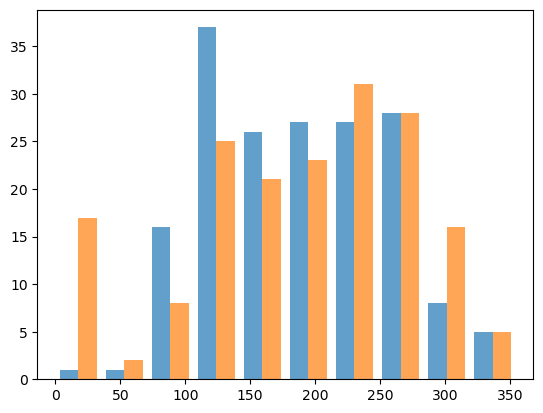

In [9]:
mode = 'LL_NMC'
a = 'Boson2BeforeFit'
b = 'Boson2AfterFit'

mask = np.array(merged[f'KinFit{mode}']['nIsoLeptons'].array() == 2)
err = np.array(merged[f'KinFit{mode}']['FitErrorCode'].array())
mask = (mask) #& (err == 0)

preFit  = np.array(merged[f'KinFit{mode}'][a].array())[mask]
postFit = np.array(merged[f'KinFit{mode}'][b].array())[mask]

plt.hist([preFit, postFit], alpha=0.7)
print(f'(Pre, Post) 0 entries = ({(preFit == 0).sum()}, {(postFit == 0).sum()})')

(array([17.,  2.,  8., 25., 21., 23., 31., 28., 16.,  5.]),
 array([  0.        ,  35.42832565,  70.85665131, 106.28498077,
        141.71330261, 177.14163208, 212.56996155, 247.99829102,
        283.42660522, 318.85494995, 354.28326416]),
 <BarContainer object of 10 artists>)

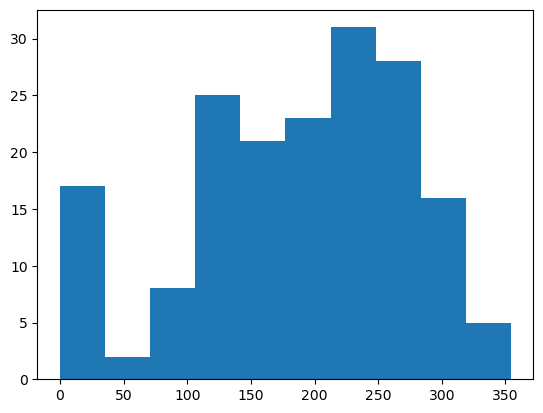

In [113]:
plt.hist(posFit)

In [66]:
np.unique(vals, return_counts=True)

<Array [[0, 1], [159, 17]] type='2 * var * int64'>

In [58]:
mask = np.array(merged[f'KinFit{ps}_ZHH']['nIsoLeptons'].array() == 2)
merged[f'KinFitLL_ZHH']['FitChi2'].array()[mask]
merged[f'KinFitLL_ZHH']['FitProbability'].array()[mask]

<Array [6.6e-25, 0, 3.94e-20, 0, ..., 0, 0, 0, 0] type='176 * float32'>

Text(0.5, 0.98, 'e2e2hh Events- ZHH KinFit')

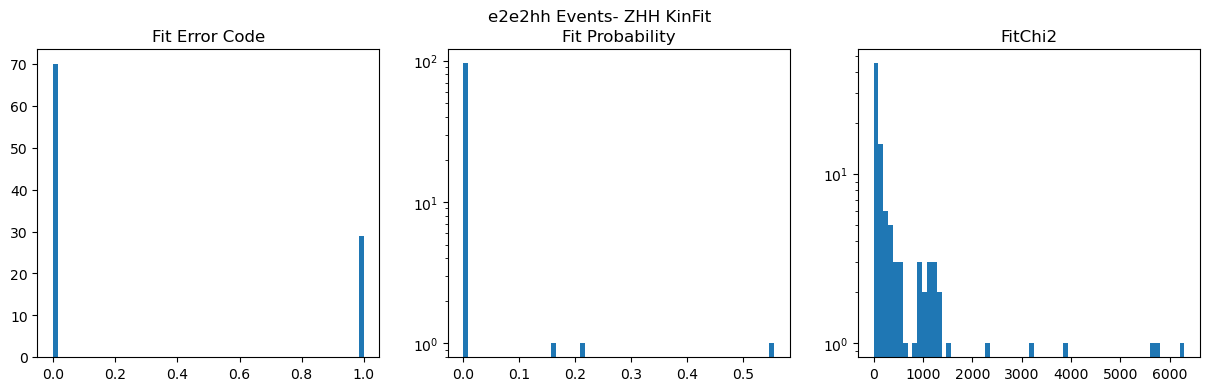

In [74]:
kwargs = { 'bins': 64 }
mask = merged['FinalStates/process'].array() == zhh.ProcessCategories.e2e2hh

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 4))
ax1.hist(merged[f'KinFitLL_ZHH']['FitErrorCode'].array()[mask], **kwargs)
ax1.set_title('Fit Error Code')

ax2.hist(merged[f'KinFitLL_ZHH']['FitProbability'].array()[mask], **kwargs)
ax2.set_yscale('log')
ax2.set_title('Fit Probability')

ax3.hist(merged[f'KinFitLL_ZHH']['FitChi2'].array()[mask], **kwargs)
ax3.set_yscale('log')
ax3.set_title('FitChi2')

fig.suptitle('e2e2hh Events- ZHH KinFit')

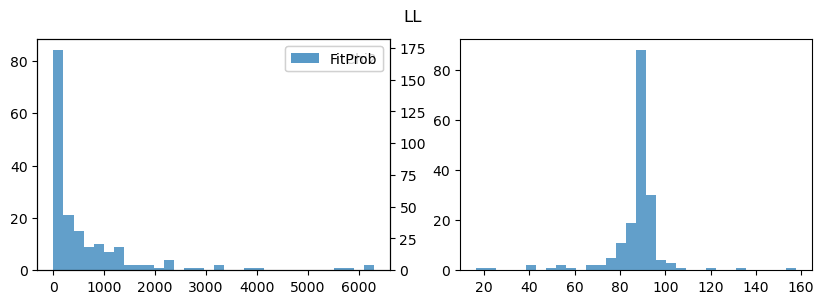

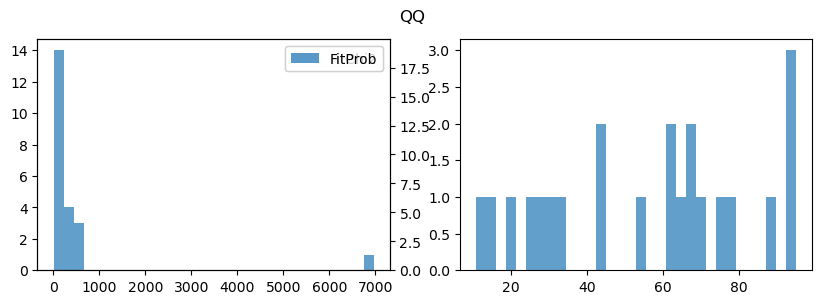

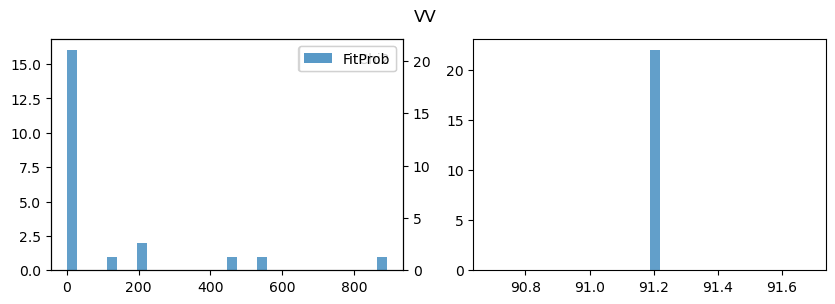

In [57]:
kwargs = {
    'bins': 32,
    'alpha': 0.7,
}

for ps, nisol in [
    ('LL', 2),
    ('QQ', 0),
    ('VV', 0)
]:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
    mask = np.array(merged[f'KinFit{ps}_ZHH']['nIsoLeptons'].array() == nisol)

    ax1.hist(merged[f'KinFit{ps}_ZHH']['FitChi2'].array()[mask], label='FitChi2', **kwargs )
    ax12 = ax1.twinx()
    ax12.hist(merged[f'KinFit{ps}_ZHH']['FitProbability'].array()[mask], label='FitProb', **kwargs )
    
    ax2.hist(merged[f'KinFit{ps}_ZHH']['Boson1BeforeFit'].array()[mask], label='Boson1BeforeFit', **kwargs )
    #ax2.hist(merged[f'KinFit{ps}_ZHH']['FitChi2'].array()[mask], label='FitChi2', **kwargs )
    #ax.hist(merged['KinFitLL_NMC']['Boson1AfterFit'].array()[mask], label='with mask', **kwargs)
    ax1.legend()
    ax12.legend()
    fig.suptitle(f'{ps}')
    plt.show()

In [ ]:
B1After = np.array(merged['KinFitLL_NMC']['Boson1AfterFit'].array())
FitCode = np.array(merged['KinFitLL_NMC']['FitErrorCode'].array())

In [51]:
FitCode[B1After == 0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [45]:
merged['KinFitLL_NMC']['Boson2AfterFit'].array()

<Array [300, 286, 147, 0, 0, ..., 262, 244, 135, 281, 0] type='198 * float32'>

(array([ 22.,   2.,   2.,   4.,   9., 144.,  12.,   1.,   1.,   1.]),
 array([  0.        ,  15.79172707,  31.58345413,  47.37517929,
         63.16690826,  78.95863342,  94.75035858, 110.54208374,
        126.33381653, 142.12553406, 157.91726685]),
 <BarContainer object of 10 artists>)

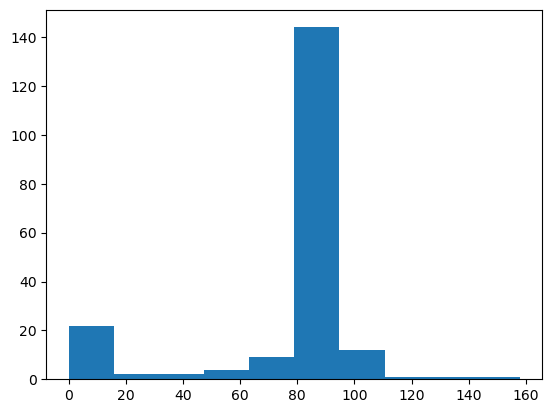

In [ ]:
plt.hist(merged['EventObservablesLL']['mzll'].array())

In [ ]:
zhh_cuts('ll')

[<Cut on nisoleps >= 2>,
 <Cut on 71.2 <= m_{Z} <= 111.2>,
 <Cut on 60.0 <= m_{H1} <= 180.0>,
 <Cut on 60.0 <= m_{H2} <= 180.0>,
 <Cut on p_{t}^{miss} <= 70.0>,
 <Cut on thrust <= 0.9>]

In [49]:
data_all = fetch_preselection_data('/home/ilc/bliewert/DevRepositories/ZHH/scripts/target.root')
data = data_all

for cut in zhh_cuts('ll'):
    print(f'length = {len(data)} prior to', cut)
    data = data[cut(data)]
    
mask = np.ones(len(data_all), dtype=bool)
mask[~np.isin(data_all['event'], data['event'])] = False

length = 198 prior to <Cut on nisoleps >= 2>
length = 177 prior to <Cut on 71.2 <= m_{Z} <= 111.2>
length = 162 prior to <Cut on 60.0 <= m_{H1} <= 180.0>
length = 159 prior to <Cut on 60.0 <= m_{H2} <= 180.0>
length = 153 prior to <Cut on p_{t}^{miss} <= 70.0>
length = 59 prior to <Cut on thrust <= 0.9>


In [ ]:
def prepare_presel_data(input, hypothesis:str):
    dtypes = []
        
    if hypothesis == '':
        
    return np.array()

In [ ]:
LL3 = AnalysisChannel('ZZH, ZZZ', [
    'EventObservablesLL/me_zhh_log',
    'EventObservablesLL/me_zzh_log',
    
    # KinFit ZHH
    'KinFitLL_ZHH/FitErrorCode',
    'KinFitLL_ZHH/Boson2AfterFit',
    'KinFitLL_ZHH/Boson3AfterFit',
    'KinFitLL_ZHH/p1stAfterFit',
    'KinFitLL_ZHH/FitChi2',
    'KinFitLL_ZHH/FitProbability',
    
    # KinFit ZZH
    'KinFitLL_ZZH/FitErrorCode',
    'KinFitLL_ZZH/Boson2AfterFit',
    'KinFitLL_ZZH/Boson3AfterFit',
    'KinFitLL_ZZH/p1stAfterFit',
    'KinFitLL_ZZH/FitChi2',
    'KinFitLL_ZZH/FitProbability',
    
    # KinFit ZZZ
    'KinFitLL_ZZZ/FitErrorCode',
    'KinFitLL_ZZZ/Boson2AfterFit',
    'KinFitLL_ZZZ/Boson3AfterFit',
    'KinFitLL_ZZZ/p1stAfterFit',
    'KinFitLL_ZZZ/FitChi2',
    'KinFitLL_ZZZ/FitProbability',
],
    define_sig=lambda data: np.isin(np.array(data['FinalStates/process'].array()), [zhh.ProcessCategories.e1e1hh, zhh.ProcessCategories.e2e2hh]),
    define_bkg=lambda data: np.isin(np.array(data['FinalStates/process'].array()), [zhh.ProcessCategories.e1e1qqh, zhh.ProcessCategories.e2e2qqh]))

<TBranch 'me_zhh_log' at 0x7fbc49d37d90>

In [19]:
sig['EventObservablesLL/me_zzh_log']

<TBranch 'me_zzh_log' at 0x7fbc49d36790>

In [6]:
from zhh import ProcessIndex

In [ ]:
ProcessIndex()

In [5]:
sig.keys()

['EventObservablesQQ;1',
 'KinFitQQ_ZZZ;2',
 'KinFitQQ_ZZZ;1',
 'KinFitQQ_ZZH;2',
 'KinFitQQ_ZZH;1',
 'KinFitQQ_ZHH;2',
 'KinFitQQ_ZHH;1',
 'KinFitQQ_NMC;2',
 'KinFitQQ_NMC;1',
 'EventObservablesVV;1',
 'KinFitVV_ZZZ;2',
 'KinFitVV_ZZZ;1',
 'KinFitVV_ZZH;2',
 'KinFitVV_ZZH;1',
 'KinFitVV_ZHH;2',
 'KinFitVV_ZHH;1',
 'KinFitVV_NMC;2',
 'KinFitVV_NMC;1',
 'EventObservablesLL;1',
 'KinFitLL_ZZZ;2',
 'KinFitLL_ZZZ;1',
 'KinFitLL_ZZH;2',
 'KinFitLL_ZZH;1',
 'KinFitLL_ZHH;2',
 'KinFitLL_ZHH;1',
 'KinFitLL_NMC;2',
 'KinFitLL_NMC;1',
 'SLDCorrection;4',
 'SLDCorrection;3',
 'SLDCorrection;2',
 'SLDCorrection;1',
 'SLDStatus;4',
 'SLDStatus;3',
 'SLDStatus;2',
 'SLDStatus;1',
 'BHadronType;4',
 'BHadronType;3',
 'BHadronType;2',
 'BHadronType;1',
 'CHadronType;4',
 'CHadronType;3',
 'CHadronType;2',
 'CHadronType;1',
 'PxResidual;8',
 'PxResidual;7',
 'PxResidual;6',
 'PxResidual;5',
 'PxResidual;4',
 'PxResidual;3',
 'PxResidual;2',
 'PxResidual;1',
 'PyResidual;8',
 'PyResidual;7',
 'PyResidua

In [19]:
rf['FinalStates'].keys()

['run',
 'event',
 'error_code',
 'final_states',
 'final_state_counts',
 'final_state_counts/final_state_counts.first',
 'final_state_counts/final_state_counts.second',
 'process',
 'event_category',
 'event_category_zhh',
 'n_fermion',
 'n_higgs',
 'n_b_from_higgs',
 'n_c_from_higgs']

In [ ]:
fsc = np.array(rf['FinalStates']['final_state_counts.second'].array())
nb = fsc[:, 4]

In [132]:
#is_signal = np.array(rf['FinalStates']['n_b_from_higgs'].array() == 4)
#is_signal = np.array(rf['FinalStates']['n_b_from_higgs'].array() == 4)
is_signal = nb == 4

In [133]:
is_signal.nbytes

3989121

In [66]:
PDGs = np.array(rf['FinalStates']['final_state_counts.first'].array(entry_start=0, entry_stop=1))
PDGs

array([[ 1,  2,  3,  4,  5,  6, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24,
        25]], dtype=int32)

In [83]:
np.unique(nb, return_counts=True)

(array([0, 1, 2, 3, 4, 6], dtype=int32),
 array([ 915880,     638, 1901912,     866,  998318,  171507]))

In [78]:
proc = np.array(rf['FinalStates']['process'].array())

In [79]:
proc

array([1511, 1511, 1511, ..., 2520, 2520, 2520], dtype=int32)